In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
import ipywidgets

import discretize
from discretize import utils
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso


import casingSimulations as casingSim

%matplotlib inline

In [4]:
simDir = "upscaling_wells"

In [5]:
casing_l = 1000
sigma_back = 0.1

In [6]:
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

model = casingSim.model.CasingInHalfspace(
    directory = simDir,
    sigma_casing = 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 3e-7,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[casing_l, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [7]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 50.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.5  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
ncy = 1
# nstretchy = 5
# stretchfact = 1.5
# hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = np.ones(ncy)
hy = hy * 2*np.pi/hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

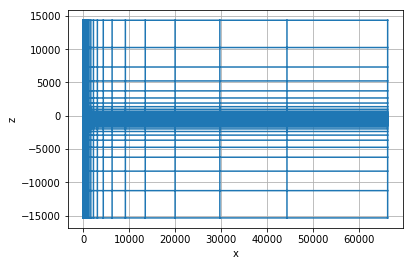

In [8]:
cylMeshGen.mesh.plotGrid()

In [10]:
physprops = casingSim.model.PhysicalProperties(cylMeshGen, model)

(-1020, 10)

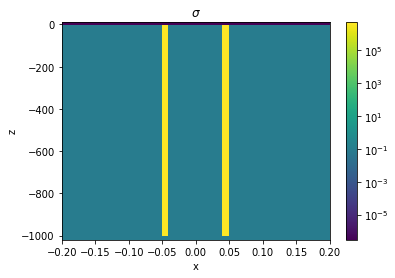

In [13]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l -20, 10]
    
theta_ind = 0


fig, ax = plt.subplots(1, 1)
physprops.plot_sigma(
    ax=ax, 
    theta_ind=theta_ind,
    pcolorOpts={'norm':LogNorm()},  # plot on a log-scale
#         clim = np.r_[1e-6, 1e2]
)
ax.set_xlim(xlim)
ax.set_ylim(zlim)